In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import latexStrings as ls
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Funciones Auxiliares

In [50]:
df = pd.read_csv("Data/wine.csv")

## Analisis exploratorio inicial (medias, varianzas, correlaciones)

Analisis exploratorio

In [3]:
# Hacer graficas

Estandarizamos los datos

In [51]:
for col in df.columns[1:]:
    mu = np.mean(df[col])
    sigma = np.std(df[col])
    df[col] = df[col].apply(lambda x: (x-mu)/sigma)

Tomamos una muestra de aproximadamente el 80% para hacer nuestro PCA. El resto se utilizara para probar la prediccion del modelo generado.

In [25]:
#pon tu cu si quieres, o quita la semilla
np.random.seed(155766)
mask = np.random.uniform(0, 1, len(df)) < 0.8
train = df[mask]
test = df[~mask]
len(train)

149

Hacemos un PCA hasta 90% de la varianza con los datos de entrenamiento estandarizados

In [26]:
# Analisis en componentes principales
pca = PCA(0.90)
X_train = pca.fit_transform(train.iloc[:, 1:].values)
#-1 para que sean 0, 1, 2
train_labels = train.iloc[:,0].values-1
Var_C = pca.explained_variance_ratio_
C = pca.components_
sum(Var_C)

0.9215145208064034

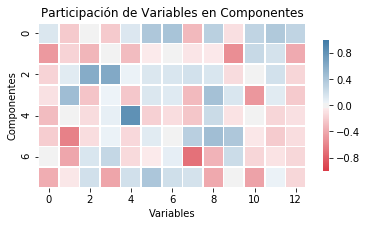

In [27]:
# Grafica departicipacion de variables en componentes
plt.title("Participación de Variables en Componentes")
cmap = sns.diverging_palette(10, 240, as_cmap=True)
sns.heatmap(C, cmap=cmap, vmin=-1, vmax=1,
            linewidths=.5, cbar_kws={"shrink": .6},
            xticklabels=2, yticklabels=2,
            square=True)
plt.xlabel("Variables")
plt.ylabel("Componentes")
plt.show()

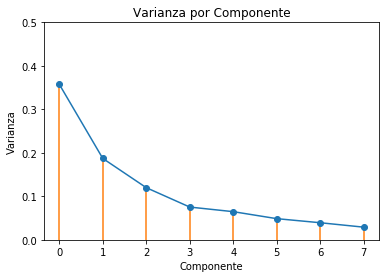

In [28]:
# Grafica de varianza acumulada
plt.title("Varianza por Componente")
plt.xlabel("Componente")
plt.ylabel("Varianza")
plt.ylim([0, 0.5])
plt.plot(range(len(Var_C)), Var_C, "-o")
plt.vlines(range(len(Var_C)), 0, Var_C, "tab:orange")
plt.show()

Grafica de Regiones a 2 componentes

Trasmformacion aplicada a datos de Test

In [29]:
X_test = pca.transform(test.iloc[:,1:].values)
test_labels = test.iloc[:,0].values-1

Grafica de regiones a 2 componentes de datos en test

## Clustering por K-Means a 3 clusters

In [45]:
# 3 grupos, centros iniciales aleatorios, tomando el mejor de 10 corridas con semilla 155766 (sklearn tiene un 
# modo que se llama k-means++ que se supone converge mas rapido)
kmeans = KMeans(3, 'random', 10, random_state=155766).fit(X_train)
#kmeans = KMeans(3, 'random', 10).fit(X_train)


Grafica de regiones a 2 componentes con nueva claisficacion

Matriz de "matches" entre grupos (i.e. cada renglon representa una region nueva, y cada columna una region vieja. La entrada i,j significa el numero de observaciones en la nueva region i que originalmente eran de la region j)

In [46]:
M = np.zeros((3,3))

for i,j in zip(kmeans.labels_,train_labels):
    M[i, j] += 1
M

array([[ 0., 51.,  0.],
       [50.,  3.,  0.],
       [ 0.,  5., 40.]])

In [47]:
# Reordenando para que quede diagonal
print(ls.latexMatrix(M[[1,0,2], :], "",eq=False))

\begin{pmatrix} 
50 & 3 & 0 \\ 
0 & 51 & 0 \\ 
0 & 5 & 40 \\ 
\end{pmatrix}


Prediccion de Datos en Test (Diagonal = correcto)

In [48]:
kmeans_test_labels = kmeans.predict(X_test)
M = np.zeros((3,3))

for i,j in zip(kmeans_test_labels,test_labels):
    M[i, j] += 1
print(ls.latexMatrix(M[[1,0,2], :], "",eq=False))

\begin{pmatrix} 
9 & 0 & 0 \\ 
0 & 11 & 0 \\ 
0 & 1 & 8 \\ 
\end{pmatrix}


## Clustering Jerarquico utilizando la regla de minima distancia maxima

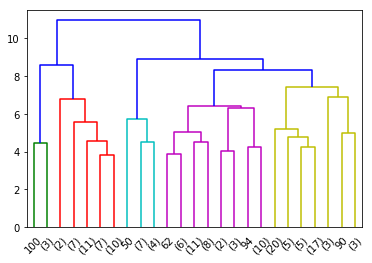

In [49]:
# Z es una estructura de como se van juntando las cosas a cada etapa del proceso
Z = sp.cluster.hierarchy.complete(X_train)
# Los numeros en parentesis son el numero de nodos chiquitos que se comio esa linea
sp.cluster.hierarchy.dendrogram(Z, 25, "lastp")
plt.show()

Grafica de regiones a 2 componentes con nueva claisficacion

In [35]:
complete_labels = sp.cluster.hierarchy.cut_tree(Z, 3).flatten()


Matriz de "matches" entre grupos

In [36]:
M = np.zeros((3,3))

for i,j in zip(complete_labels,train_labels):
    M[i, j] += 1
M

array([[48., 48.,  0.],
       [ 2.,  2., 37.],
       [ 0.,  9.,  3.]])

In [37]:
print(ls.latexMatrix(M[[0,2,1], :], "",eq=False))

\begin{pmatrix} 
48 & 48 & 0 \\ 
0 & 9 & 3 \\ 
2 & 2 & 37 \\ 
\end{pmatrix}


Prediccion

In [38]:
complete_test_labels = np.array([np.argmin(
                                [max(
                                        np.linalg.norm(x-y) for y in X_train[complete_labels == i]
                                    ) for i in range(3)]
                                ) 
                                for x in X_test])
M = np.zeros((3,3))

for i,j in zip(complete_test_labels, test_labels):
    M[i, j] += 1
print(ls.latexMatrix(M[[0,2,1], :], "",eq=False))

\begin{pmatrix} 
5 & 1 & 0 \\ 
1 & 10 & 5 \\ 
3 & 1 & 3 \\ 
\end{pmatrix}


## Clustering Jerarquico utilizando la regla de Ward (min distancia cuadrada entre clusters)

https://www.stat.cmu.edu/~cshalizi/350/lectures/08/lecture-08.pdf

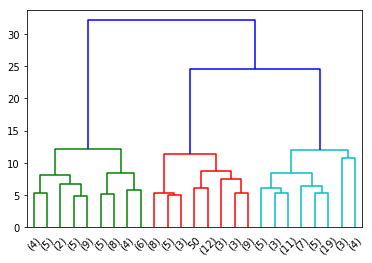

In [39]:
# Z es una estructura de como se van juntando las cosas a cada etapa del proceso
Z = sp.cluster.hierarchy.ward(X_train)
# Los numeros en parentesis son el numero de nodos chiquitos que se comio esa linea
sp.cluster.hierarchy.dendrogram(Z, 25, "lastp")
plt.show()

Grafica de regiones a 2 componentes con nueva claisficacion

In [40]:
ward_labels = sp.cluster.hierarchy.cut_tree(Z, 3).flatten()

Matriz de "matches" entre grupos

In [41]:
M = np.zeros((3,3))

for i,j in zip(ward_labels,train_labels):
    M[i, j] += 1
M

array([[50.,  7.,  0.],
       [ 0., 44.,  0.],
       [ 0.,  8., 40.]])

In [42]:
print(ls.latexMatrix(M, "",eq=False))

\begin{pmatrix} 
50 & 7 & 0 \\ 
0 & 44 & 0 \\ 
0 & 8 & 40 \\ 
\end{pmatrix}


Prediccion

In [43]:
def ward_test(X, y):
    # Hay q minimizar la varianza que se genera cuando se agrega y a algun cluster
    X_center = sum(X)/len(X)
    diff = (len(X)/(len(X) + 1)) * (np.linalg.norm(X_center - y))
    return diff

In [44]:
ward_test_labels = np.array([np.argmin([ward_test(X_train[ward_labels == i], x)
                                for i in range(3)])
                            for x in X_test])
M = np.zeros((3,3))

for i,j in zip(ward_test_labels, test_labels):
    M[i, j] += 1
print(ls.latexMatrix(M, "",eq=False))

\begin{pmatrix} 
9 & 0 & 0 \\ 
0 & 11 & 0 \\ 
0 & 1 & 8 \\ 
\end{pmatrix}
